## NiN Net in Net 网络中的网络

### NiN块的构成
* 一个卷积层和两个全连接层
* 其中两个全连接层是两个1x1的卷积块 padding=0 stride=1
* 输出入形状和输出相同

### NiN架构
* 无全连接层
* 交替使用NiN块和3x3,stride=2的Pooling层
    * 逐步减少高宽和增大通道数
* 最后使用全局平均池化层得到输出 GAP GlobalAvgPool
    * 其通道数是类别数

In [5]:
%load_ext viztracer
import torch
import torch.nn as nn
import lmy

The viztracer extension is already loaded. To reload it, use:
  %reload_ext viztracer


In [6]:
def nin_block(in_channels,out_channels,kernel_size,strides,padding):
    """nin块的设计"""
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding), nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU()
    )

In [7]:
net = nn.Sequential(
    nin_block(in_channels=1, out_channels=96, kernel_size=11, strides=4,padding=0),
    nn.MaxPool2d(3,stride=2),
    nin_block(in_channels=96, out_channels=256, kernel_size=5, strides=1,padding=2),
    nn.MaxPool2d(3,stride=2),
    nin_block(in_channels=256, out_channels=384, kernel_size=3, strides=1,padding=1),
    nn.MaxPool2d(3,stride=2), nn.Dropout(),
    nin_block(in_channels=384,out_channels=10,kernel_size=3,strides=1,padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

查看每个块的输出形状

In [8]:
%%viztracer
X = torch.rand((1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, f'输出形状:{X.shape}')


Sequential 输出形状:torch.Size([1, 96, 54, 54])
MaxPool2d 输出形状:torch.Size([1, 96, 26, 26])
Sequential 输出形状:torch.Size([1, 256, 26, 26])
MaxPool2d 输出形状:torch.Size([1, 256, 12, 12])
Sequential 输出形状:torch.Size([1, 384, 12, 12])
MaxPool2d 输出形状:torch.Size([1, 384, 5, 5])
Dropout 输出形状:torch.Size([1, 384, 5, 5])
Sequential 输出形状:torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d 输出形状:torch.Size([1, 10, 1, 1])
Flatten 输出形状:torch.Size([1, 10])


Button(description='VizTracer Report', style=ButtonStyle())

FashionMNIST数据集加载成功，训练集大小:60000,测试集大小:10000,数据集shape:torch.Size([1, 224, 224])
设备数量不足,已自动调整
训练设备[device(type='cpu')]


  0%|          | 0/10 [00:04<?, ?epoch/s]


KeyboardInterrupt: 

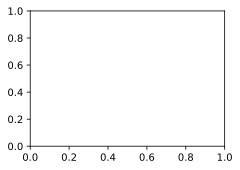

In [9]:
lr, num_epochs, batch_size = .05, 10, 128
train_iter, test_iter = lmy.loadFashionMnistData(batch_size, '../lmy/data/', resize=224)
devices = lmy.getGPU(contain_cpu=False)
if len(devices) == 0:
    devices = [torch.device('cpu')]
lmy.train_GPU(net, train_iter, test_iter, num_epochs, lr, devices=devices, num_devices=2)

In [ ]:
def a(x):
    return x+1

In [ ]:
%%viztracer 
print(a(5))

In [12]:
%%viztracer 
print(a(5))

6


Button(description='VizTracer Report', style=ButtonStyle())